## Stateful ConvLSTM for Binrary Calcium Fluorescence Video Segmentation

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import keras
import cv2
import h5py

/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [ ]:
frame_no = 0
cap = cv2.VideoCapture('neurofinder_data/01.00.label.tif') #video_name is the video being called
cap.set(1,frame_no); # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
plt.imshow(frame)
plt.show()
print(frame.max(), frame.min())
cap = cv2.VideoCapture('neurofinder_data/01.00.avi') #video_name is the video being called
cap.set(1,frame_no); # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
print(type(frame))
plt.imshow(frame)
plt.show()
print(frame.max(), frame.min())
print(type(frame))

The input images thus need to be normalised because values are not within the range of 0 and 1. This will hopefully help the network to optimise better

DEFINE MODEL AND TRAINING PROCEDURE

In [2]:
from keras.utils import plot_model
from keras.layers import (ConvLSTM2D, BatchNormalization, Convolution3D, Convolution2D,Conv2D,
                          TimeDistributed, MaxPooling2D, UpSampling2D, Input, merge, Cropping2D, concatenate)


In [ ]:
#unet model
def tsu_net(batch_size, true_frag_len):
    #This is not a sequential model because sequential models are specifically for
    # linear sequences
    #recurrent_activation='hard_sigmoid'
    c = 12
    input_shape = (None, 256, 256, 1)

    input = Input(batch_shape= [batch_size, true_frag_len, 256,256, 1])
    # 256,256
    x = TimeDistributed(Conv2D(filters=3, 
                               kernel_size=(3,3), 
                               padding='same',
                               activation='relu'))(input)
    x = TimeDistributed(Conv2D(filters=3, 
                               kernel_size=(3,3), 
                               padding='same',
                               activation='relu'))(x)
    c1 = ConvLSTM2D(filters=8, kernel_size=(3, 3),
                       input_shape=input_shape,
                       padding='same', 
                       return_sequences=True,
                       stateful = True)(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(c1)
    
    #128,128
    x = TimeDistributed(Conv2D(filters=3, 
                               kernel_size=(3,3), 
                               padding='same',
                               activation='relu'))(x)
    x = TimeDistributed(Conv2D(filters=3, 
                               kernel_size=(3,3), 
                               padding='same',
                               activation='relu'))(x)
    c2 = ConvLSTM2D(filters=8, kernel_size=(3,3), 
                    padding='same', 
                    return_sequences=True,
                    activation='tanh')(x)
    
    x = TimeDistributed(MaxPooling2D((2, 2), (2, 2)))(c2)
    x = TimeDistributed(Conv2D(filters=3, 
                               kernel_size=(3,3), 
                               padding='same',
                               activation='relu'))(x)
    x = TimeDistributed(Conv2D(filters=3, 
                               kernel_size=(3,3), 
                               padding='same',
                               activation='relu'))(x) 
    c3 = ConvLSTM2D(filters=8, kernel_size=(3, 3),
                       input_shape=input_shape,
                       padding='same', 
                       return_sequences=True,
                       stateful = True)(x)

    # pool: 24 27 24
    x = TimeDistributed(MaxPooling2D((2, 2), (2, 2)))(c3)
    x = TimeDistributed(Conv2D(filters=3, 
                               kernel_size=(3,3), 
                               padding='same',
                               activation='relu'))(x)
    x = TimeDistributed(Conv2D(filters=3, 
                               kernel_size=(3,3), 
                               padding='same',
                               activation='relu'))(x)
    c4 = ConvLSTM2D(filters=8, kernel_size=(3, 3),
                       input_shape=input_shape,
                       padding='same', 
                       return_sequences=True,
                       stateful = True)(x)
    # upsl: 48 54 24
    upsl_1 = TimeDistributed(UpSampling2D((2, 2)))(c4)
    #x = TimeDistributed(Conv2D(filters=c, kernel_size=(2,2), padding='same',activation='relu'))(x)
    x = merge([c3, upsl_1], mode='concat')
    x = TimeDistributed(Conv2D(filters=c, kernel_size=(3,3), padding='same',activation='relu'))(x)
    x = TimeDistributed(Conv2D(filters=c, kernel_size=(3,3), padding='same',activation='relu'))(x)

    # upsl: 96 108 24
    upsl_2 = TimeDistributed(UpSampling2D((2, 2)))(x)
    #x = TimeDistributed(Conv2D(filters=c, kernel_size=(2,2), padding='same',activation='relu'))(x)
    x = merge([c2, upsl_2], mode='concat')
    x = TimeDistributed(Conv2D(filters=3, kernel_size=(3,3), padding='same',activation='relu'))(x)
    x = TimeDistributed(Conv2D(filters=3, kernel_size=(3,3), padding='same',activation='relu'))(x)

    # upsl: 192 216 24
    upsl_3 = TimeDistributed(UpSampling2D((2, 2)))(x)
    #x = TimeDistributed(Conv2D(filters=c, kernel_size=(2,2), padding='same',activation='relu'))(x)
    x = merge([c1, upsl_3], mode='concat')
    x = TimeDistributed(Conv2D(filters=3, kernel_size=(3,3), padding='same',activation='relu'))(x)
    #x = TimeDistributed(Conv2D(filters=3, kernel_size=(3,3), padding='same',activation='relu'))(x)


    # upsl: 384 432
    #upsl_4 = TimeDistributed(UpSampling2D((2, 2)))(x)
    #x = TimeDistributed(Conv2D(filters=2, kernel_size=(3,3), padding='same',activation='relu'))(upsl_4)
    output = TimeDistributed(Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid'), name='output')(x)
    model = Model(input, output=[output])
    #model.compile(loss='binary_crossentropy', optimizer = 'adadelta', metrics = ['binary_accuracy'])
    model.compile(loss='binary_crossentropy', optimizer = 'adadelta')

    model.summary()
    return model

In [ ]:
#simple mini batch model
from keras.models import Model
from keras.layers.convolutional import Conv3D, Conv2D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, TimeDistributed
import keras.backend as K
import tensorflow as tf
from keras.optimizers import *

from keras.layers import (ConvLSTM2D, BatchNormalization, Convolution3D, Convolution2D,Conv2D,
                          TimeDistributed, MaxPooling2D, UpSampling2D, Input, merge, Cropping2D, concatenate)


K.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0})))

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)



def load_model(batch_size,true_frag_len):
    input_shape = (None, 256, 256, 1)
    input = Input(batch_shape= [batch_size, true_frag_len, 256,256, 1])
    
    x = TimeDistributed(Conv2D(filters=2, kernel_size=(3,3), padding='same',activation='relu'))(input)
    x = TimeDistributed(MaxPooling2D((2, 2), (2, 2)))(x)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(filters=14, kernel_size=(3, 3),
                       input_shape=input_shape,
                       padding='same', 
                       return_sequences=True,
                       stateful = True)(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(Conv2D(filters=2, kernel_size=(3,3), padding='same',activation='relu'))(x)
    
    upsl_1 = TimeDistributed(UpSampling2D((2, 2)))(x)
    output = TimeDistributed(Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid'), name='output')(upsl_1)
    # output = Conv3D(filters=1, kernel_size=(3, 3, 3),
    #                    activation='sigmoid',
    #                    padding='same', data_format='channels_last')(x)


    model_stateful_batch = Model(inputs = [input], output=[output])
    #model_stateful_batch.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model_stateful_batch.compile(loss='binary_crossentropy', optimizer= 'adadelta')

    model_stateful_batch.summary()
    return model_stateful_batch

In [ ]:
import time
def train_model(model, no_samples, no_frags, generator,valid_generator,epochs, frag_len, model_validator):
    print("Training for " + str(epochs) + " epochs")
    #training_losses = []
    epoch_times = []
    for epoch in range(epochs):
        epoch_time = time.time()
        print("Number of training reps per epoch " + str(no_samples))
        for reps in range(reps_for_samples):
            if reps%(no_frags) == 0:
               #print ('Time to reset states')
                model.reset_states()
            train_loss = 0
            X,Y = next(generator.generate())
            train_loss += model.train_on_batch(X, Y)
            #print ('# Fragement ', reps, '  loss ', train_loss)
            #training_losses.append(train_loss)
           # print(training_losses)
            #if reps%no_frags == 0:
            if reps%50 == 0:
                print ('# Iteration', reps, '  loss ', train_loss)
                #print(train_loss)
        print ('# Epoch', epoch + 1, '  loss ', train_loss)
        model.reset_states()
        print("Done training")
        print("Traing loss " + str(train_loss))
        #print("Validating")
        duration = time.time()- epoch_time
        epoch_times.append(duration)
        
    
    try:
        model_validator.validate(model,no_frags, frag_len, valid_generator)
        return model, epoch_times
    except IOError:
        print("Validation could not be performed")
    else:
         # we don't want to catch the IOError if it's raised
        return model, epoch_times
        
    
    

In [9]:
from skimage import measure
from regional import many
from neurofinder import centers, shapes
from skimage.filters import threshold_yen
from skimage.morphology import closing, square
from skimage.filters import threshold_yen, threshold_isodata, threshold_otsu

class Validate_and_Metrics(object):
    

    def __init__(self, model, no_frags):
        self.precisions = []
        self.recalls = []
        self.f1scores = []
        self.model = model
        self.no_frags = no_frags
        self.dims = (256,256)
        
    def validate(self, model, frag_len, valid_generator):
        self.frag_len = frag_len
        ypred = self.batch_prediction(valid_generator)
        # this frag len is not defined so we need a way to get it in here
        # the true one needs to be normalised to be compared properly
        ytrue = self.ytrue_for_validation()
        #we need the last result of all the fragments
        ypred_ind = ypred[no_frags-1][0][frag_len-1].reshape(self.dims)
        print(ypred_ind.shape)
        thresh = threshold_isodata(ypred_ind)
        ypred_thresh = (closing(ypred_ind > thresh, square(3)))*255

        print(ytrue.max(), ytrue.min())
        print(ypred_thresh.max(), ypred_thresh.min())
        #print(ytrue.reshape(256,400).shape)
        #print(ypred.reshape(256,400).shape)
        the_metric = self.nf_mask_metrics(ytrue.reshape(self.dims),ypred_thresh.reshape(self.dims))
        #print(the_metric)
        
    def ytrue_for_validation(self):
        vect = cv2.VideoCapture("neurofinder_data/04.01.label.tif")
        vect.set(1,1)
        ret,lab_frame = vect.read()
        lab_frame = cv2.resize(lab_frame,( (self.dims[1], self.dims[0])))
        lab_frame = cv2.cvtColor(lab_frame, cv2.COLOR_BGR2GRAY)
        return lab_frame
    
    def batch_prediction(self, generator):
    # this just tests out one sample. I think it is necessary to reset states on prediction too
        stateful_preds = []
        self.model.reset_states()
        gen = generator.generate()
        for fragment in range(self.no_frags):
            X,Y = next(gen)
            stateful_batch = self.model.predict_on_batch(X)
            stateful_preds.append(stateful_batch)
        return stateful_preds
    
    
    def _mask_to_regional(self, m):
        """Convert a 2D numpy mask to a regional many object so it can be measured
        using the neurofinder library."""
        mlbl = measure.label(m,background=255 )
        coords = []
        for lbl in range(1, np.max(mlbl) + 1):
            yy, xx = np.where(mlbl == lbl)
            coords.append([[y, x] for y, x in zip(yy, xx)])
       
        return many(coords)
    
    def nf_mask_metrics(self, m, mp):
        """Computes precision, recall, inclusion, exclusion, and combined (F1) score for the given mask (m) and predicted mask (mp). Note that this does assumes single 2D masks and does not aaccount for overlapping neurons.

        # Arguments
            m: ground-truth (height x width) binary numpy mask.
            mp: predicted (height x width) binary numpy mask.

        # Returns
            p,r,i,e,f1: precision, recall, inclusion, exclusion, and F1 scores.

        """
        # Return all zeros if the predicted mask is empty.
        if np.sum(mp.round()) == 0:
            return 0., 0., 0., 0., 0.
        
        #print(type(m))
        #print(type(mp))
        #print(m.shape)
        #print(mp.shape)
        # Convert masks to regional format and compute their metrics.
        mreg = self._mask_to_regional(m)
        #print(type(mreg))
        print(mreg)
        mpreg = self._mask_to_regional(mp)
        #print(type(mpreg))
        print(mpreg)

        #r, p = centers(mreg, mpreg,threshold = 5 )
        r, p = centers(mreg, mpreg,threshold = 5 )

        i, e = shapes(mreg, mpreg)
        f1 = 2. * (r * p) / (r + p)
        self.precisions.append(p)
        self.recalls.append(r)
        self.f1scores.append(f1)
        print(self.precisions, self.recalls, self.f1scores)
        return (p, r, i, e, f1)
    
    def get_metrics(self):
        return {
            'precisions': self.precisions,
            'recalls':self.recalls,
            'f1scores':self.f1scores
        }
    

/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [ ]:
ey = measure.label(bw, background=255)
ey.shape
plt.imshow(ey)
plt.show

In [ ]:
from skimage.filters import threshold_yen, threshold_isodata, threshold_otsu
from skimage.morphology import closing, square

ypred_test = predicted[4]
thresh = threshold_isodata(ypred_test)
bw = (closing(ypred_test > thresh, square(3)))*255
#threshpredicted = (ypred_test>thresh)*255
print(bw.shape)

ytrue_test = validator.ytrue_for_validation()
print(bw.shape, ytrue_test.shape)
validator.nf_mask_metrics(ytrue_test.reshape(256,256),bw.reshape(256,256))

plt.imshow(bw, cmap = 'gray')
plt.show()
print('Max value: ' + str(bw.max()))

plt.imshow(ytrue_test, cmap = 'gray')
plt.show()
print('Max value: ' + str(y[0][0].max()))

In [ ]:
validator.get_metrics()

## STOCHASTIC
## STATEFUL batch_shape = [1, frag_len, x, y, 1]
    1 sample at a time
    update made after no_fragments batches
    y = [1, 1, x, y, 1]

DEFINE DATA FEEDER

There are two ways to sample the data as illustrated below. Check it out. The only difference is how indexes are defined for data range of each fragment and then the no of resulting fragments.

no of fragments and length of fragments changes with the step size so the real length becomes (frag_len+1)/steps and number of fragments is (data_len-frag_len + 1)/steps

In [ ]:
example = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20, 21, 22]
data_len = len(example)
frag_len = 11
steps = 2
no_frags = int((data_len-frag_len + 1)/steps)
print(no_frags)

for current_count in range(no_frags):
    #ranger = list(range(current_count,current_count+ frag_len))
    indx = np.arange(current_count*steps,current_count*steps+ frag_len, steps)
    print(np.array(example)[indx.astype(int)])
(np.array(example)[indx.astype(int)]).shape

no of fragments does not change with the step size but, the actual length of the fragment is changed by the step size. so the real length becomes (frag_len+1)/steps 

In [ ]:
example = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20, 21, 22]
data_len = len(example)
frag_len = 11
steps = 2
no_frags = int(data_len-frag_len + 1)
print(no_frags)

for current_count in range(no_frags):
    #ranger = list(range(current_count,current_count+ frag_len))
    indx = np.arange(current_count,current_count+ frag_len, steps)
    print(np.array(example)[indx.astype(int)])
(np.array(example)[indx.astype(int)])

Quick check to make sure the data is loaded correctly by the data generator. Also a quick check to make sure the images returned are nomalised (value range between 0 and 1). 

NB. Make sure current sample number of next output block is the same as the label vect that is read by cv2 when drawing otherwise images wont match and you might think it is not working

In [ ]:
class Batch_size_1_Generator(object):

    def __init__(self, frag_len, steps = 1, valid = False):
        self.frag_len = frag_len
        #print(frag_len)
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        self.current_count = 0
        self.data = None
        # dimensions expected by the network
        self.dims = (256,256)
        self.steps = steps
        self.valid = valid
    
        #self.dup_rows()
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set

    def dup_rows(self, a, indx, num_dups=1):
        return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)
    
    def _resizeNnormalize(self, data, dimso):
        """
        data : the image to be resized 
        dimso : the dimensions to be resized to (tuple)
        """
        data = cv2.resize(data, dimso)
        img = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
        nomalized = img/255
        return nomalized
    
    
    def generate(self):
        # this generator returns no_frag fragments for each sample before moving to the next sample
        data_array = ['01.00','01.01','02.00','02.01','04.00','04.01']
        while True:
            if self.valid == True:
                self.current_idx = '04.01'
                #if self.current_count == 0:
                    #print('Validating')
            elif self.current_count == 0:
                self.current_idx = data_array[np.random.randint(6)]
                print("Current sample is : " + self.current_idx)
            video = cv2.VideoCapture('neurofinder_data/' + self.current_idx + '.avi')

            data_len = 500
            # find out number of fragments for data
            no_frags = int((data_len-self.frag_len + 1)/self.steps)
            #no_frags = int(data_len/frag_len)
            
            #print("No frags inside " + str(no_frags))
            self.current_count += 1
            #print('current sample number: ' + str(self.current_idx)+', Fragment ' + str(self.current_count)+ ' of ' + str(no_frags))
            
            if self.current_count == no_frags:
                #print(self.current_count)
                self.current_count = 0
            data_range = (self.current_count,self.current_count+ self.frag_len)
            #print(data_range)
            
            x = []

            # data_range is the range of frames to be fetched for each fragment
            indxs = np.arange(self.current_count*steps,self.current_count*steps+ frag_len, steps)
            #indxs = np.arange(self.current_count*self.frag_len,(self.current_count+1)* self.frag_len, steps)

            #for indexer in range(data_range[0],data_range[1]):
            for indexer in indxs:

                video.set(1,indexer) # Where frame_no is the frame you want
                ret, frame = video.read() # Read the frame
                x.append(self._resizeNnormalize(frame, self.dims))
         
            #print('No frags ' + str(no_frags))
            
             
            labels = cv2.VideoCapture('neurofinder_data/' + self.current_idx + '.label.tif')
            labels.set(1,1)
            ret,lab_frame = labels.read()
            y = []
            for indx in range(len(x)):
            #for indx in range(int((self.frag_len+1)/self.steps)-1):
                y.append(self._resizeNnormalize(lab_frame, self.dims))
                
            y = np.expand_dims(y, axis=-1)
            x = np.expand_dims(x, axis=-1)
            y = np.expand_dims(y, axis=0)
            x = np.expand_dims(x, axis=0)
           
            #yield x,y
            yield x,y
            

In [ ]:
# Set params batch size 1
data_len = 500
steps = 2
frag_len = 40
true_frag_len = int((frag_len+1)/steps)
no_frags = int((data_len-frag_len + 1)/steps)
print(no_frags)
batch_size = 1
no_videos = 6
reps_for_samples = no_videos*no_frags
print(reps_for_samples)
epochs = 5

Check to see if Generator is loading data correctly

In [ ]:
print('True fragment length ' +str(true_frag_len))
gener_obj = Batch_size_1_Generator(frag_len, steps)
gener = gener_obj.generate()
X,y = next(gener)
X.shape, y.shape

In [ ]:
vect = cv2.VideoCapture("neurofinder_data/01.01.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(256,256))

plt.imshow(lab_frame, cmap = 'gray')
plt.show()
print('Max value: ' + str(lab_frame.max()))

plt.imshow(y[0][0].reshape(256,256), cmap = 'gray')
plt.show()
print('Max value: ' + str(y[0][0].max()))

plt.imshow(X[0][0].reshape(256,256), cmap = 'gray')
plt.show()
print('Max value: ' + str(X[0][0].max()))

TRAIN

In [ ]:
model_stateful_batch1 = load_model(batch_size,true_frag_len)

In [ ]:
model_stateful_batch1 = tsu_net(batch_size,true_frag_len)

In [ ]:
gener = Batch_size_1_Generator(frag_len, steps)
valid_generator = Batch_size_1_Generator(frag_len, steps, valid = True)
validator = Validate_and_Metrics(model_stateful_batch1,no_frags )
model_stateful_batch1_trained, epoch_execution_time = train_model(model_stateful_batch1, reps_for_samples, no_frags, gener,valid_generator,epochs, true_frag_len, validator)

In [ ]:
stocahstic_metrics = validator.get_metrics()
stocahstic_metrics

In [ ]:
stochastic_execution_time = epoch_execution_time
stochastic_execution_time

In [ ]:
save_model(model_stateful_batch1_trained, 'stochastic_5e_frag_40_step_2_len500_vid6')

PREDICT ON TRAINED MODEL

In [ ]:
# Predict using just a single sample loaded from file
gener_1 = Batch_size_1_Generator(frag_len, steps)
# this just tests out one sample. I think it is necessary to reset states on prediction too
stateful_preds = validator.batch_prediction(gener_1)

In [ ]:
len(stateful_preds), stateful_preds[0].shape

In [ ]:
#first is fragment, second is the only one sample
predicted = stateful_preds[15][0].reshape(true_frag_len,256,256)

vect = cv2.VideoCapture("neurofinder_data/01.00.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(256,256))
#truth = lab_frame[0].reshape(256,400)
plt.imshow(lab_frame, cmap = 'gray')
plt.show()

#frame in fragment, goes up to fragment length
plt.imshow(predicted[4], cmap = 'gray')
plt.show()

In [ ]:
#fig, ax = try_all_threshold(predicted[1], figsize=(10, 8), verbose=False)
thresh = threshold_yen(predicted[4])
plt.imshow(predicted[1]>thresh,  cmap = 'gray')
plt.show(thresh, )

## Mini-batch
## STATEFUL batch_shape = [batch_size, frag_len, x, y, 1]
    8 samples at a time
    update made after no_fragments batches
    y = [8, 1, x, y, 1]

In [5]:
class Batch_size_n_Generator(object):

    def __init__(self, batch_size,frag_len,steps = 1,valid = False):
        self.frag_len = frag_len
        #print(frag_len)
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idxs = [] 
        self.current_count = 0
        self.data = None
        # dimensions expected by the network
        self.dims = (256,256)
        self.steps = steps
        self.batch_size = batch_size
        self.valid = valid
    
        #self.dup_rows()
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set

    def dup_rows(self, a, indx, num_dups=1):
        return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)
    
    def _resizeNnormalize(self, data, dimso):
        """
        data : the image to be resized 
        dimso : the dimensions to be resized to (tuple)
        """
        data = cv2.resize(data, (self.dims[1],self.dims[0]))
        img = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
        nomalized = img/255
        return nomalized
    
    def _fetchframes(self, indxs, video):
        frames = []
        for indexer in indxs:
            video.set(1,indexer) # Where frame_no is the frame you want
            ret, frame = video.read() # Read the frame
            frames.append(self._resizeNnormalize(frame, self.dims))
        return(frames)
    
    def _fetchlabels(self, label, true_frag_len):
        frames = []
        label.set(1,1)
        ret,lab_frame = label.read()
        label_frame = self._resizeNnormalize(lab_frame, self.dims) 
        y = [label_frame for indx in range(true_frag_len)]
        return(y)
    
    
    def generate(self):
        # this generator returns no_frag fragments for each sample before moving to the next sample
        data_array = ['00.00','01.00','01.01','02.00','02.01','04.00','04.01']
        while True:
            if self.valid == True:
                self.current_idxs = [ data_array[np.random.randint(6)] for item in range(self.batch_size)]
                
                if self.current_count == 0:
                    print('Validating')
            elif self.current_count == 0:
                self.current_idxs = [data_array[np.random.randint(6)] for i in range(self.batch_size)]
                print(self.current_idxs)
            
            #self.data = [np.load('dummies/video_' + str(ind) + '.npy') for ind in self.current_idxs]
            self.data = [cv2.VideoCapture('neurofinder_data/' + ind + '.avi') for ind in self.current_idxs]
            #self.data = [cv2.VideoCapture('neurofinder_data/00.00.avi') for ind in range(3)]
            data_len = 500
            # find out number of fragments for data
            no_frags = int((data_len-self.frag_len + 1)/self.steps)
            #no_frags = int(data_len/frag_len)
            
            #print("No frags inside " + str(no_frags))
            self.current_count += 1
            #print('current sample number: ' + str(self.current_idxs)+', Fragment ' + str(self.current_count)+ ' of ' + str(no_frags))
            
            if self.current_count == no_frags:
                print(self.current_count)
                self.current_count = 0
            

            # data_range is the range of frames to be fetched for each fragment
            indxs = np.arange(self.current_count*steps,self.current_count*steps+ frag_len, steps)
            x = [self._fetchframes(indxs,video) for video in self.data]
                
 
    
            labels = [(cv2.VideoCapture('neurofinder_data/' + str(ind) + '.label.tif')) for ind in self.current_idxs]
            y = [self._fetchlabels(lebel, len(x[0])) for lebel in labels]
           
                
            y = np.expand_dims(y, axis=-1)
            x = np.expand_dims(x, axis=-1)

            yield x,y
            

In [6]:
# Set params batch size n
data_len = 500
steps = 2
frag_len = 40
true_frag_len = int((frag_len+1)/steps)
no_frags = int((data_len-frag_len + 1)/steps)
batch_size = 3
no_videos = 6
no_batches = int(no_videos/batch_size)
reps_for_samples = no_batches*no_frags
print(reps_for_samples)
epochs = 5

460


Check that generator is producing the right data

In [ ]:
print('True fragment length ' +str(true_frag_len))
gener_obj = Batch_size_n_Generator(batch_size,frag_len,steps)
gener = gener_obj.generate()
X,y = next(gener)
X.shape, y.shape

In [ ]:
vect = cv2.VideoCapture("neurofinder_data/01.00.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(256,256))
#truth = lab_frame[0].reshape(256,256)
plt.imshow(lab_frame, cmap = 'gray')
plt.show()
print('Max value: ' + str(lab_frame.max()))

plt.imshow(y[0][0].reshape(256,256), cmap = 'gray')
plt.show()
print('Max value: ' + str(y[0][0].max()))

plt.imshow(X[0][1].reshape(256,256), cmap = 'gray')
plt.show()
print('Max value: ' + str(X[0][0].max()))

TRAIN ON MODEL

In [ ]:
model_stateful_batchn = load_model(batch_size,true_frag_len)

In [ ]:
model_stateful_batchn = tsu_net(batch_size,true_frag_len)

In [ ]:
gener = Batch_size_n_Generator(batch_size,frag_len,steps)
valid_generator = Batch_size_n_Generator(batch_size, frag_len, steps, valid = True)
validator_n = Validate_and_Metrics()
model_stateful_batchn_trained, epoch_execution_timemini = train_model(model_stateful_batchn, reps_for_samples, no_frags, gener,valid_generator,epochs, true_frag_len,validator_n )

In [ ]:
minibatch_metrics = validator_n.get_metrics()
minibatch_metrics

In [ ]:
minibatch_execution_time = epoch_execution_timemini
minibatch_execution_time

In [ ]:
save_model(model_stateful_batchn_trained, 'minibatch_5e_frag_40_step_2_len500_vid6')

PREDICT ON TRAINED MODEL

In [ ]:
gener_n = Batch_size_n_Generator(batch_size, frag_len, steps)
# this just tests out one sample. I think it is necessary to reset states on prediction too
# Predict using just a single sample loaded from file
stateful_preds_n = validator_n.batch_prediction(gener_n)

In [ ]:
len(stateful_preds_n), stateful_preds_n[0].shape

In [ ]:
# Second index is the video number, first index the fragment 
predictedn = stateful_preds_n[229][2].reshape(true_frag_len,256,256)

vect = cv2.VideoCapture("neurofinder_data/01.01.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(256,256))
#truth = lab_frame[0].reshape(256,256)
plt.imshow(lab_frame, cmap = 'gray')
plt.show()

#predicted result
# this index is the frame in the fragment
plt.imshow(predictedn[19], cmap = 'gray')
plt.show()

In [ ]:
from skimage.filters import try_all_threshold

#fig, ax = try_all_threshold(predicted[1], figsize=(10, 8), verbose=False)
thresh = threshold_yen(predicted[1])
plt.imshow(predictedn[1]>thresh,  cmap = 'gray')
plt.show(thresh, )

# Evaluation Analysis

Average Run time per epoch

In [ ]:
print ("Stochastic: " + str(np.mean(stochastic_execution_time)) + " +/- " + str(np.std(stochastic_execution_time))) 

In [ ]:
print ("Mini-batch: " + str(np.mean(minibatch_execution_time)) + " +/- " + str(np.std(minibatch_execution_time))) 

 Plot of F1 scores and Precision and Recall

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.set(xlabel='Epoch', ylabel='F1score',
       title='Mean F1score per epoch')
plt.plot(minibatch_metrics['f1scores'], label='Mini-batch')
plt.plot(stocahstic_metrics['f1scores'],linestyle='dashdot',label='Stochastic')
plt.legend();

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.set(xlabel='Epoch', ylabel='precisions',
       title='Mean precisions per epoch')
plt.plot(minibatch_metrics['precisions'], label='Mini-batch')
plt.plot(stocahstic_metrics['precisions'],linestyle='dashdot',label='Stochastic')
plt.legend();

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.set(xlabel='Epoch', ylabel='recalls',
       title='Mean recalls per epoch')
plt.plot(minibatch_metrics['recalls'], label='Mini-batch')
plt.plot(stocahstic_metrics['recalls'],linestyle='dashdot',label='Stochastic')
plt.legend();

In [ ]:
minibatch_metrics,stocahstic_metrics

Mean F1 score, precision and recall on test set

In [ ]:
def save_model(model,name):
    # Creates a HDF5 file 'my_model.h5'
    model.save(name + '.h5')

## TRANSFER LEARNING

In [4]:
from keras.models import load_model
model = load_model('minibatch_5e_frag_40_step_2_len500_vid6.h5')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/keras/engine/topology.py:1242: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [29]:
gener_transfer = Batch_size_n_Generator(batch_size, frag_len, steps)

In [30]:
validator = Validate_and_Metrics(model, no_frags)

In [31]:
transfer_result = validator.batch_prediction(gener_transfer)

['01.01', '04.00', '00.00']
230


In [12]:
len(transfer_result), transfer_result[0].shape

(230, (3, 20, 256, 256, 1))

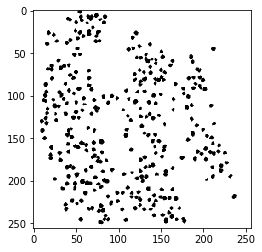

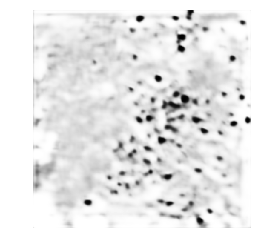

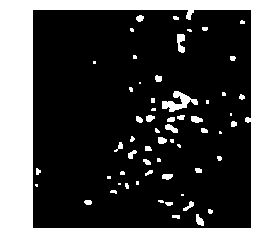

In [32]:
# Second index is the video number, first index the fragment 
predictedn = transfer_result[229][0].reshape(true_frag_len,256,256)

vect = cv2.VideoCapture("neurofinder_data/00.00.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(256,256))
#truth = lab_frame[0].reshape(256,256)
plt.imshow(lab_frame, cmap = 'gray')
plt.show()

#predicted result
# this index is the frame in the fragment
plt.axis("off")
plt.imshow(cv2.resize(predictedn[19],(512,512)), cmap = 'gray')
plt.show()

#predicted result
# this index is the frame in the fragment
thresh = threshold_yen(predictedn[19])
ypred_thresh = (closing(predictedn[19] > thresh, square(3)))
plt.axis("off")
plt.imshow(ypred_thresh, cmap = 'gray_r')
plt.show()

In [ ]:
truth = "/home/pelonomi/Desktop/thesis_images/01.01.label.png"
pred = "/home/pelonomi/Desktop/thesis_images/01.01_unet2ds.png"

def loadimg(path):
    vect = cv2.VideoCapture(path)
    vect.set(1,1)
    ret,lab_frame = vect.read()
    lab_frame = cv2.resize(lab_frame,(256,256))
    lab_frame = cv2.cvtColor(lab_frame, cv2.COLOR_BGR2GRAY)
    return lab_frame